# K-means 聚类算法
- **优点**:最常见,最通用的算法.易于理解与实现
- **缺点**:
    1. 容易将学习数据分为相差不多的两堆数据,和我们的数据特点(代学行为用户占比8%左右)不一样,所以需要调整算法参数,才能得到更好的结果。
    2. 每次都随机选择初始中心点,导致结果不可复现

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置中文显示
from pylab import mpl

# 机器学习相关
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 一、数据预处理
### 1 加载数据集

In [68]:
f1 = '../../data/周一所获数据/所有学员的学习总时长ms.csv'
f2 = '../../data/周一所获数据/所有学员的OPENID使用情况.csv'
f3 = '../../data/周一所获数据/所有学员的IP使用情况.csv'

df_duration = pd.read_csv(f1, dtype={'trainingPersonId': 'string', 'totalDuration': 'float64'})
df_openid = pd.read_csv(f2, dtype={'openIdCount': 'int64', 'openIds': 'string'})
df_ip = pd.read_csv(f3, dtype={'_id': 'string', 'ipCount': 'int'})

### 2 合并单个大特征表

In [69]:
df_intermedia_1 = pd.merge(df_duration, df_openid, left_on='trainingPersonId', right_on='_id', how='inner')
df_intermedia_2 = pd.merge(df_intermedia_1, df_ip, left_on='_id', right_on='_id', how='inner')

df_final = df_intermedia_2[["_id", "openIdCount", "ipCount", "totalDuration"]]
df_final[["totalDuration"]] = df_final[["totalDuration"]] / 1000 / 60 / 60  # 转换为小时

C:\Users\fjhb\AppData\Local\Temp\ipykernel_17076\2940720877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[["totalDuration"]] = df_final[["totalDuration"]] / 1000 / 60 / 60  # 转换为小时


In [70]:
df_final.to_csv("./3-features.csv", index=False)

---
# 二、机器学习
### 1 K-means

In [78]:
# 数据归一化
scaler = MinMaxScaler()
train_x = scaler.fit_transform(df_final.drop("_id", axis=1))

In [76]:
classifier = KMeans(n_clusters=2, n_init='auto')
classifier.fit(train_x)

labels = classifier.labels_
centers = classifier.cluster_centers_

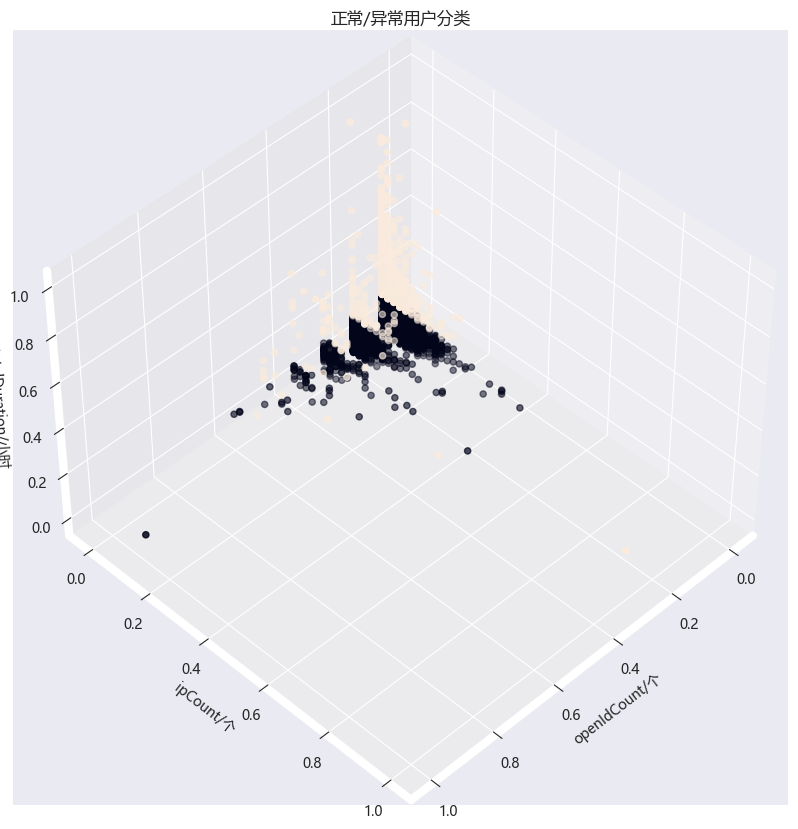

In [77]:
plt.rcParams['axes.linewidth'] = 6
fig = plt.figure(figsize=(10, 20))

ax = fig.add_subplot(projection="3d", elev=45, azim=45)

ax.set_xlabel("openIdCount/个")
ax.set_ylabel("ipCount/个")
ax.set_zlabel("totalDuration/小时")

ax.scatter(train_x[:, 0], train_x[:, 1], train_x[:, 2], c=labels)
# ax.scatter(centers[0,:], centers[1,:])

plt.title("正常/异常用户分类")

# plt.savefig("./imgs/Kmeans-3-features(归一化).png")
plt.show()


C:\Users\fjhb\.conda\envs\ML_for_Training_Monitor\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\fjhb\.conda\envs\ML_for_Training_Monitor\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\fjhb\.conda\envs\ML_for_Training_Monitor\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\fjhb\.conda\envs\ML_for_Training_Monitor\lib\site-packages\sklearn\cluster\_km

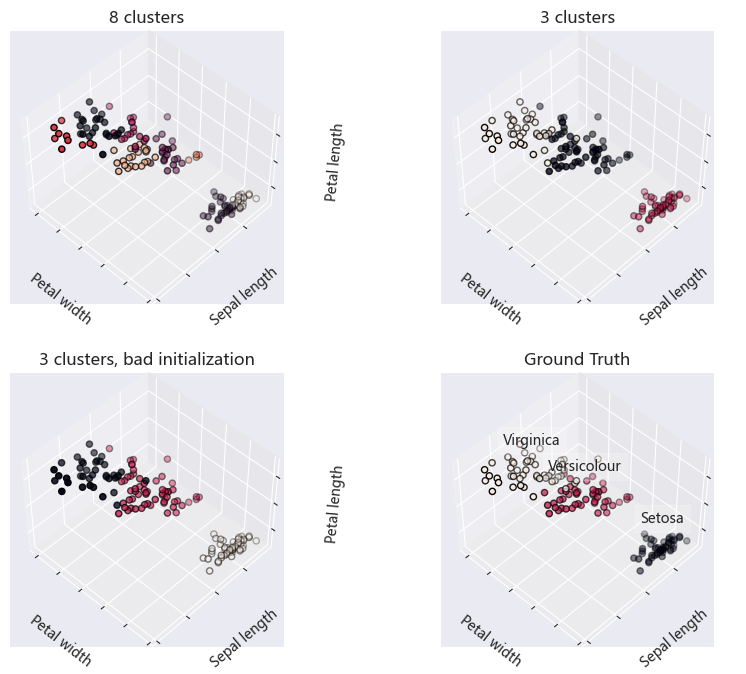

In [6]:
# 3D 绘图样例
np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [
    ("k_means_iris_8", KMeans(n_clusters=8)),
    ("k_means_iris_3", KMeans(n_clusters=3)),
    ("k_means_iris_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig_1 = plt.figure(figsize=(10, 8))
titles_1 = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("Petal width")
    ax.set_ylabel("Sepal length")
    ax.set_zlabel("Petal length")
    ax.set_title(title)

# Plot the ground truth
ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )

ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
ax.set_title("Ground Truth")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()